<a href="https://colab.research.google.com/github/Joohii/Permutation-Learning-Technex/blob/main/Technex_Mlware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#ensure that all the columns are read as string
d1 = {}
for i in range(6):
    for j in range(6):
        d1[str(i)+str(j)] = str

#load dataframe
df_faces = pd.read_csv("/content/drive/MyDrive/Mlware/Mlware/train/train_faces.csv", dtype = d1)

In [ ]:
#ensure that all the columns are read as string
d2 = {}
for i in range(6):
    for j in range(6):
        d2[str(i)+str(j)] = str

#load dataframe
df_landmarks = pd.read_csv("/content/drive/MyDrive/Mlware/Mlware/train/train_landmarks.csv", dtype = d2)

In [ ]:
test_df_faces = pd.DataFrame({"image": os.listdir("/content/drive/MyDrive/Mlware/Mlware/test/faces")})

In [ ]:
test_df_landmarks = pd.DataFrame({"image": os.listdir("/content/drive/MyDrive/Mlware/Mlware/test/landmarks")})

In [ ]:
#train test split of faces
n1 = len(df_faces)
val_split = 0.2
val_df_faces = df_faces[:int(n1*val_split)]
train_df_faces = df_faces[int(n1*val_split):]

In [ ]:
#train test split of landmarks
n2 = len(df_landmarks)
val_split = 0.2
val_df_landmarks = df_landmarks[:int(n2*val_split)]
train_df_landmarks = df_landmarks[int(n2*val_split):]

In [ ]:
# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a seperate array
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        if df.equals(train_df_faces) or df.equals(val_df_faces):
            img = Image.open("/content/drive/MyDrive/Mlware/Mlware/train/faces/"+img_name)
        elif df.equals(train_df_landmarks) or df.equals(val_df_landmarks):
            img = Image.open("/content/drive/MyDrive/Mlware/Mlware/train/landmarks/"+img_name)
        elif df is test_df_faces:
            img = Image.open("/content/drive/MyDrive/Mlware/Mlware/test/faces/"+img_name)
        elif df is test_df_landmarks:
            img = Image.open("/content/drive/MyDrive/Mlware/Mlware/test/landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [ ]:
train_faces_img = load_images(train_df_faces)
val_faces_img = load_images(val_df_faces)

100%|██████████| 19/19 [00:00<00:00, 166.66it/s]


In [ ]:
train_landmarks_img = load_images(train_df_landmarks)
val_landmarks_img = load_images(val_df_landmarks)

100%|██████████| 600/600 [01:28<00:00,  6.80it/s]


In [ ]:
test_faces_img = load_images(test_df_faces)

100%|██████████| 900/900 [03:08<00:00,  4.78it/s]


In [ ]:
test_landmarks_img = load_images(test_df_landmarks)

100%|██████████| 1096/1096 [02:46<00:00,  6.57it/s]


In [ ]:
print(train_faces_img.shape)
print(val_faces_img.shape)
#100 puzzles, 36 pieces, each piece is a 50x50x3 image

(80, 36, 50, 50, 3)
(19, 36, 50, 50, 3)


In [ ]:
print(train_landmarks_img.shape)
print(val_landmarks_img.shape)
#3000 puzzles, 36 pieces, each piece is a 50x50x3 image

(2400, 36, 50, 50, 3)
(600, 36, 50, 50, 3)


In [ ]:
print(test_faces_img.shape)
print(test_landmarks_img.shape)

(900, 36, 50, 50, 3)
(1096, 36, 50, 50, 3)


In [ ]:
'''
a function that one hot encodes the given labels.
we have a total of 36 puzzle pieces and 36 possible positions for each of those pieces
if piece at index i has its correct position at index j, we make label[i][j] = 1 
and all the other values in label[i] are set to 0

we iterate through all positions using i and j.
for each position, its index out of 36 will be i*6+j 
and same for the value in that column
'''
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

In [ ]:
train_labels_faces = load_labels(train_df_faces)
val_labels_faces = load_labels(val_df_faces)
#100 puzzles, 36x36 one hot encoded matrix as output
print(train_labels_faces.shape)
print(val_labels_faces.shape)
#100 puzzles, 36x36 one hot encoded matrix as output

100%|██████████| 19/19 [00:00<00:00, 933.78it/s]

(80, 36, 36)
(19, 36, 36)


In [ ]:
train_labels_landmarks = load_labels(train_df_landmarks)
val_labels_landmarks = load_labels(val_df_landmarks)
#3000 puzzles, 36x36 one hot encoded matrix as output
print(train_labels_landmarks.shape)
print(val_labels_landmarks.shape)
#3000 puzzles, 36x36 one hot encoded matrix as output

100%|██████████| 600/600 [00:00<00:00, 812.67it/s]

(2400, 36, 36)
(600, 36, 36)


In [ ]:
#MODEL ARCHITECTURE for faces
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once
#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(2, (2,2), strides=2)
conv2 = tf.keras.layers.Conv2D(2, (2,2), strides=2)
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)
dense2 = tf.keras.layers.Dense(36)
dense3 = tf.keras.layers.Dense(36)
dense4 = tf.keras.layers.Dense(36)
dense5 = tf.keras.layers.Dense(36)
#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = conv2(x)
    x = flat(x)
    x = dense1(x)
    x = dense2(x)
    x = dense3(x)
    x = dense4(x)
    x = dense5(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

# define the checkpoint filepath
filepath_faces = "best_model_faces.h5"

# define the callback to save the best model based on validation accuracy
checkpoint_faces= ModelCheckpoint(filepath_faces, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')
model_faces = tf.keras.Model(inputs=inp, outputs=x)
model_faces.compile(optimizer="adam", loss="categorical_crossentropy", metrics="CategoricalAccuracy")

model_faces.fit(x=train_faces_img, 
          y=train_labels_faces, 
          batch_size=4, 
          validation_data=[val_faces_img, val_labels_faces], 
          shuffle=True,
          epochs=100,
          callbacks=[checkpoint_faces])

Epoch 1/500
19/20 [===========================>..] - ETA: 0s - loss: 56.5947 - categorical_accuracy: 0.0325
Epoch 1: val_categorical_accuracy improved from -inf to 0.03801, saving model to best_model_faces.h5
20/20 [==============================] - 9s 156ms/step - loss: 54.9018 - categorical_accuracy: 0.0326 - val_loss: 25.1052 - val_categorical_accuracy: 0.0380
Epoch 2/500
20/20 [==============================] - ETA: 0s - loss: 18.8457 - categorical_accuracy: 0.0427
Epoch 2: val_categorical_accuracy improved from 0.03801 to 0.05848, saving model to best_model_faces.h5
20/20 [==============================] - 2s 78ms/step - loss: 18.8457 - categorical_accuracy: 0.0427 - val_loss: 14.8634 - val_categorical_accuracy: 0.0585
Epoch 3/500
20/20 [==============================] - ETA: 0s - loss: 12.0553 - categorical_accuracy: 0.0514
Epoch 3: val_categorical_accuracy did not improve from 0.05848
20/20 [==============================] - 2s 81ms/step - loss: 12.0553 - categorical_accuracy: 0

In [ ]:
#MODEL ARCHITECTURE for landmarks
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once
#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(2, (2,2), strides=2)
conv2 = tf.keras.layers.Conv2D(2, (2,2), strides=2)
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)
dense2 = tf.keras.layers.Dense(36)
dense3 = tf.keras.layers.Dense(36)
#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = conv2(x)
    x = flat(x)
    x = dense1(x)
    x = dense2(x)
    x = dense3(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

# define the checkpoint filepath
filepath_landmarks = "best_model_landmarks.h5"

# define the callback to save the best model based on validation accuracy
checkpoint_landmarks = ModelCheckpoint(filepath_landmarks, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')
model_landmarks = tf.keras.Model(inputs=inp, outputs=x)
model_landmarks.compile(optimizer="adam", loss="categorical_crossentropy", metrics="CategoricalAccuracy")

model_landmarks.fit(x=train_landmarks_img, 
          y=train_labels_landmarks, 
          batch_size=8, 
          validation_data=[val_landmarks_img, val_labels_landmarks], 
          shuffle=True,
          epochs=100,
          callbacks=[checkpoint_landmarks])

Epoch 1/150
300/300 [==============================] - ETA: 0s - loss: 29.8427 - categorical_accuracy: 0.0352
Epoch 1: val_categorical_accuracy improved from -inf to 0.03731, saving model to best_model_landmarks.h5
300/300 [==============================] - 28s 76ms/step - loss: 29.8427 - categorical_accuracy: 0.0352 - val_loss: 7.3447 - val_categorical_accuracy: 0.0373
Epoch 2/150
300/300 [==============================] - ETA: 0s - loss: 5.1476 - categorical_accuracy: 0.0387
Epoch 2: val_categorical_accuracy improved from 0.03731 to 0.04370, saving model to best_model_landmarks.h5
300/300 [==============================] - 23s 76ms/step - loss: 5.1476 - categorical_accuracy: 0.0387 - val_loss: 4.1042 - val_categorical_accuracy: 0.0437
Epoch 3/150
300/300 [==============================] - ETA: 0s - loss: 3.8625 - categorical_accuracy: 0.0417
Epoch 3: val_categorical_accuracy did not improve from 0.04370
300/300 [==============================] - 21s 71ms/step - loss: 3.8625 - categor

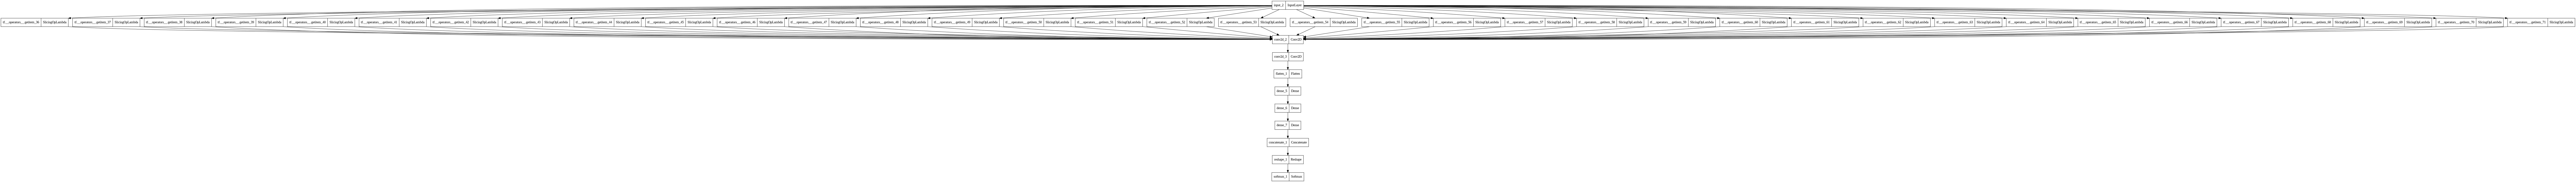

In [ ]:
tf.keras.utils.plot_model(model_faces)
tf.keras.utils.plot_model(model_landmarks)
# an image of our model architecture
# double click to expand

In [ ]:
pred_faces = model_faces.predict(test_faces_img)
pred_faces = np.argmax(pred_faces, axis=-1)

29/29 [==============================] - 9s 194ms/step


In [ ]:
pred_landmarks = model_landmarks.predict(test_landmarks_img)
pred_landmarks = np.argmax(pred_landmarks, axis=-1)

35/35 [==============================] - 9s 218ms/step


In [ ]:
print(pred_faces.shape)
print(pred_faces)
# 19 puzzles, 36 predicted permutations
print(pred_faces[0])
#predicted permutation for 0th puzzle

(900, 36)
[[26  8 35 ... 30 19 25]
 [ 2 28 14 ... 24 21 14]
 [20 10  5 ...  0 22 16]
 ...
 [ 0 11 28 ...  4 17 16]
 [15  8  7 ... 11  8  5]
 [ 6 14  3 ... 10 21 10]]
[26  8 35 14 17 22 10 14 16  4  6 33 19 21 16 15 34 22 13  4 35 19 18 33
 23 29 34  2 13 21  6 24 20 30 19 25]


In [ ]:
print(pred_landmarks.shape)
print(pred_landmarks)
# 19 puzzles, 36 predicted permutations
print(pred_landmarks[0])
#predicted permutation for 0th puzzle

(1096, 36)
[[ 3 16  3 ...  3 30 33]
 [13 16  0 ... 26 32  7]
 [14 15 35 ... 17  3 20]
 ...
 [ 9 28  0 ...  0  0 34]
 [13 18  3 ...  7  9 25]
 [ 6  4  0 ... 35  2 15]]
[ 3 16  3 10 17 30 22 20 35 32 17 28 18 27 35  9  8  5  3  2 30 12  5  7
 23 17 24 24 10 35 31 25 18  3 30 33]


In [ ]:
#formatting our predictions into pandas dataframe for faces
pred_list_faces = []
for i in range(pred_faces.shape[0]):
    t = []
    for j in range(pred_faces[i].shape[0]):
        t.append(str(pred_faces[i][j]//6) + str(pred_faces[i][j]%6))
    pred_list_faces.append(t)

image_df = pd.DataFrame(test_df_faces["image"])
label_df = pd.DataFrame(pred_list_faces)
out_faces = pd.concat([image_df, label_df], axis=1)
out_faces.columns = df_faces.columns
out_faces

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,F0JIEFGwNj.jpg,42,12,55,22,25,34,14,22,24,...,54,02,21,33,10,40,32,50,31,41
1,P56LhEymet.jpg,02,44,22,21,22,24,20,23,15,...,35,13,40,34,13,23,40,40,33,22
2,AgmXafAAiS.jpg,32,14,05,33,01,44,14,52,50,...,11,20,03,30,35,23,31,00,34,24
3,7uJVvrA1MV.jpg,35,12,40,15,10,04,41,00,22,...,12,05,42,31,15,05,10,01,00,41
4,4L7nI0NyNb.jpg,31,51,15,05,13,25,04,01,01,...,00,30,00,21,00,24,51,23,34,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,c2Lt7hHbnV.jpg,42,31,23,24,05,45,11,04,25,...,10,50,02,13,10,52,10,55,30,24
896,esAvQnw4At.jpg,12,35,42,52,00,20,45,41,34,...,53,14,51,35,30,50,35,00,34,10
897,w6QSsKyeny.jpg,00,15,44,03,52,54,01,40,44,...,45,00,04,05,55,52,24,04,25,24
898,qNMScrq4eB.jpg,23,12,11,23,35,04,50,53,45,...,31,22,15,41,41,51,21,15,12,05


In [ ]:
#formatting our predictions into pandas dataframe for landmarks
pred_list_landmarks = []
for i in range(pred_landmarks.shape[0]):
    t = []
    for j in range(pred_landmarks[i].shape[0]):
        t.append(str(pred_landmarks[i][j]//6) + str(pred_landmarks[i][j]%6))
    pred_list_landmarks.append(t)

image_df = pd.DataFrame(test_df_landmarks["image"])
label_df = pd.DataFrame(pred_list_landmarks)
out_landmarks = pd.concat([image_df, label_df], axis=1)
out_landmarks.columns = df_landmarks.columns
out_landmarks

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,GFgxqNcO4o.jpg,03,24,03,14,25,50,34,32,55,...,40,40,14,55,51,41,30,03,50,53
1,GUc4MQ8wZr.jpg,21,24,00,34,20,55,34,35,53,...,53,11,55,50,20,50,33,42,52,11
2,0PfWjutRo7.jpg,22,23,55,04,25,01,35,55,55,...,23,20,30,50,04,15,15,25,03,32
3,IRCvnQgZ9e.jpg,24,50,00,24,23,55,55,33,23,...,41,43,45,23,53,35,24,41,35,35
4,75BIkQEo75.jpg,55,30,31,05,04,55,45,52,15,...,45,45,45,50,21,55,35,04,35,03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,IrFN1gw9Ty.jpg,55,41,25,51,03,20,45,40,01,...,04,35,13,50,04,54,50,55,00,04
1092,8sYWHSwhrI.jpg,12,03,45,41,40,02,32,51,02,...,03,04,25,32,54,21,40,31,00,12
1093,BkSQG38V2x.jpg,13,44,00,40,20,05,55,03,04,...,13,10,05,10,23,04,45,00,00,54
1094,FV6YkVxvbw.jpg,21,30,03,54,03,45,35,00,35,...,45,33,23,31,11,14,04,11,13,41


In [ ]:
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    if df.equals(train_df_faces) or df.equals(val_df_faces):
        im = Image.open("/content/drive/MyDrive/Mlware/Mlware/train/faces/"+img_name)
    elif df.equals(train_df_landmarks) or df.equals(val_df_landmarks):
        im = Image.open("/content/drive/MyDrive/Mlware/Mlware/train/landmarks/"+img_name)
    # elif df is out_faces:
    #     im = Image.open("/content/drive/MyDrive/Mlware/Mlware/test/faces/"+img_name)
    elif df is out_landmarks:
        im = Image.open("/content/drive/MyDrive/Mlware/Mlware/test/landmarks/"+img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'predicted')

<Figure size 432x288 with 0 Axes>

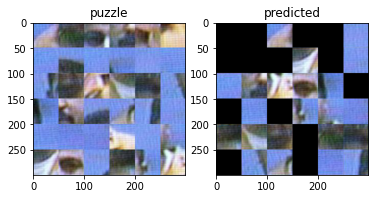

In [ ]:
puzzle, predicted = rearrange(out_faces, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(predicted)
axarr[1].set_title("predicted")
#predictions are bad as expected for faces

Text(0.5, 1.0, 'predicted')

<Figure size 432x288 with 0 Axes>

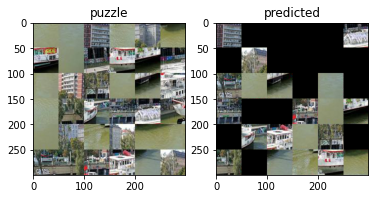

In [ ]:
puzzle, predicted = rearrange(out_landmarks, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(predicted)
axarr[1].set_title("predicted")
#predictions are bad as expected for landmarks

In [ ]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [ ]:
submission_faces = prediction_to_submission(out_faces)

In [ ]:
submission_landmarks = prediction_to_submission(out_landmarks)

In [ ]:
submission_faces

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,F0JIEFGwNj.jpg,4,1,5,2,2,3,1,2,2,...,4,2,1,3,0,0,2,0,1,1
1,P56LhEymet.jpg,0,4,2,2,2,2,2,2,1,...,5,3,0,4,3,3,0,0,3,2
2,AgmXafAAiS.jpg,3,1,0,3,0,4,1,5,5,...,1,0,3,0,5,3,1,0,4,4
3,7uJVvrA1MV.jpg,3,1,4,1,1,0,4,0,2,...,2,5,2,1,5,5,0,1,0,1
4,4L7nI0NyNb.jpg,3,5,1,0,1,2,0,0,0,...,0,0,0,1,0,4,1,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,c2Lt7hHbnV.jpg,4,3,2,2,0,4,1,0,2,...,0,0,2,3,0,2,0,5,0,4
896,esAvQnw4At.jpg,1,3,4,5,0,2,4,4,3,...,3,4,1,5,0,0,5,0,4,0
897,w6QSsKyeny.jpg,0,1,4,0,5,5,0,4,4,...,5,0,4,5,5,2,4,4,5,4
898,qNMScrq4eB.jpg,2,1,1,2,3,0,5,5,4,...,1,2,5,1,1,1,1,5,2,5


In [ ]:
submission_landmarks
# we do this inference for testing data of landscape as well as faces dataset and then concatenate the dataframes

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,GFgxqNcO4o.jpg,0,2,0,1,2,5,3,3,5,...,0,0,4,5,1,1,0,3,0,3
1,GUc4MQ8wZr.jpg,2,2,0,3,2,5,3,3,5,...,3,1,5,0,0,0,3,2,2,1
2,0PfWjutRo7.jpg,2,2,5,0,2,0,3,5,5,...,3,0,0,0,4,5,5,5,3,2
3,IRCvnQgZ9e.jpg,2,5,0,2,2,5,5,3,2,...,1,3,5,3,3,5,4,1,5,5
4,75BIkQEo75.jpg,5,3,3,0,0,5,4,5,1,...,5,5,5,0,1,5,5,4,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,IrFN1gw9Ty.jpg,5,4,2,5,0,2,4,4,0,...,4,5,3,0,4,4,0,5,0,4
1092,8sYWHSwhrI.jpg,1,0,4,4,4,0,3,5,0,...,3,4,5,2,4,1,0,1,0,2
1093,BkSQG38V2x.jpg,1,4,0,4,2,0,5,0,0,...,3,0,5,0,3,4,5,0,0,4
1094,FV6YkVxvbw.jpg,2,3,0,5,0,4,3,0,3,...,5,3,3,1,1,4,4,1,3,1
